In [ ]:
Entreno de un ConvNet InceptionV3 preentrenado con Imagenet y
entrenando conjunto de datos pequeño
Conjunto de datos de 4 clases
Utilizaremos un conjunto de datos reducido:
- Conjunto de entrenamiento: 1.000 muestras x clase 
- Conjunto de validación: 300 muestras x clase
- Conjunto de test: 300 muestras x clase
El conjunto de datos: balanced_dataset
contiene tres carpetas, train, validation y test, cada una con 4 clases

In [16]:
from keras.preprocessing.image  import ImageDataGenerator, img_to_array, load_img 
from keras.models  import Sequential
from keras.layers  import Dropout,  Flatten,  Dense, GlobalAveragePooling2D, Input
from keras.applications import InceptionV3
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical 
import time
import os
import numpy as np 
import math
import  matplotlib.pyplot  as  plt

width_image = 299
height_image = 299
batch_size = 64 
epochs = 90
nb_train = 4000
nb_validation = 1200
nb_test = 1200
nb_classes = 4
nb_FC = 1024
channels_image = 3

class_mode = 'categorical'
train_dir  =  "balanced_dataset/train"
validation_dir = "balanced_dataset/validation" 
test_dir  =  "balanced_dataset/test" 


In [3]:
from keras.applications import InceptionV3

conv_base= InceptionV3(weights='imagenet', 
                 include_top = False, 
                 input_shape = (width_image, height_image, channels_image))

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
#Extracción de características del modelo Preentrenado y nuestro dataset
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

#Tamaño de salida de la última capa convoluciónal del modelo preentrenado
#lo vemos en el conv_base.summary()
out_x = 8
out_y = 8
conv_len = 2048

datagen = ImageDataGenerator(rescale = 1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, out_x, out_x, conv_len))
    labels = to_categorical(np.zeros(shape=(sample_count)),nb_classes) #INDICAR NUMERO DE CLASES
    generator = datagen.flow_from_directory(
        directory,
        target_size = (height_image, width_image),
        batch_size = batch_size,
        #classes = 4,
        class_mode = 'categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) ##Asociamos al modelo preentrenado
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

#Train: 1000 muestras x clase, con 4 clases, 1000 x 4 = 4000
train_features, train_labels = extract_features(train_dir, nb_train)
#validation 500 muestras x clase con 4 clases, 300 x 4 = 1200
validation_features, validation_labels = extract_features(validation_dir, nb_validation) 
#test 500 muestras x clase con 4 clases, 300 x 4 = 1200
test_features, test_labels = extract_features(test_dir, nb_test)


Found 4000 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [7]:
np.save('InceptionV3/InceptionV3_FE_NS_train_1.npy',  train_features)
np.save('InceptionV3/InceptionV3_FE_NS_validation_1.npy',  validation_features)

In [8]:
print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(4000, 8, 8, 2048)
(1200, 8, 8, 2048)
(1200, 8, 8, 2048)


In [12]:
#Save Features
train_data = np.load('InceptionV3/InceptionV3_FE_NS_train_1.npy') 
validation_data  =  np.load('InceptionV3/InceptionV3_FE_NS_validation_1.npy')

In [6]:
#Las características extraídas están como muetras en forma (muestra, 4, 4, 512).-->(muestras, out_x, out_y, conv_len)
#Debemos aplanarlas (muestras, 8192) para alimentar un clasificador densamente conectado 4x4x512 = 8192 si entrada 150x150
#Debemos aplanarlas (muestras, 25088) para alimentar un clasificador densamente conectado 7x7x512 = 25088 si entrada 224x224


train_features = np.reshape(train_features, (nb_train, out_x * out_y * conv_len))
validation_features = np.reshape(validation_features, (nb_validation, out_x * out_y * conv_len))
test_features = np.reshape(test_features, (nb_test, out_x * out_y * conv_len))
print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(4000, 51200)
(1200, 51200)
(1200, 51200)


In [19]:
from keras.models  import Model
# add a global spatial average pooling layer
inputTensor = Input((8,8,2048)) #Use (None,None,2048) if bottlenecks vary in size    
x = GlobalAveragePooling2D()(inputTensor)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer -- let's say we have 2 classes
predictions = Dense(nb_classes, activation='softmax')(x)

# What is the correct input? Obviously not base_model.input.
model = Model(inputTensor, predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in conv_base.layers:
    layer.trainable = False

In [21]:
#Compile models
model.compile(
    optimizer = RMSprop(lr=2e-5),
    loss='categorical_crossentropy',  
    metrics=['accuracy'])


In [22]:
#Train model

history = model.fit(
    train_data, 
    train_labels,
    epochs=epochs,  
    batch_size=batch_size, 
    validation_data=(validation_data, validation_labels))


Train on 4000 samples, validate on 1200 samples
Epoch 1/90
4000/4000 [==============================] - 5s 1ms/step - loss: 1.1671 - acc: 0.5067 - val_loss: 1.0343 - val_acc: 0.5925
Epoch 2/90
4000/4000 [==============================] - 4s 967us/step - loss: 0.9771 - acc: 0.6175 - val_loss: 0.9299 - val_acc: 0.6308
Epoch 3/90
4000/4000 [==============================] - 4s 944us/step - loss: 0.8862 - acc: 0.6607 - val_loss: 0.8576 - val_acc: 0.6758
Epoch 4/90
4000/4000 [==============================] - 3s 821us/step - loss: 0.8285 - acc: 0.6880 - val_loss: 0.8067 - val_acc: 0.6992
Epoch 5/90
4000/4000 [==============================] - 3s 856us/step - loss: 0.7836 - acc: 0.7075 - val_loss: 0.7653 - val_acc: 0.7083
Epoch 6/90
4000/4000 [==============================] - 4s 892us/step - loss: 0.7459 - acc: 0.7242 - val_loss: 0.7577 - val_acc: 0.6983
Epoch 7/90
4000/4000 [==============================] - 3s 863us/step - loss: 0.7167 - acc: 0.7298 - val_loss: 0.7234 - val_acc: 0.7225
Ep

In [23]:
#Guardamos el modelo
# h5py 
model.save_weights('InceptionV3/InceptionV3_FE_NS_model_1.h5')

In [24]:
def print_graphics (history):
    #Mostramos otro tipo de grafico
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+ 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    #plt.tittle('Trainning and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    #plt.tittle('Trainning and validation loss')
    plt.legend()

    plt.show()

In [25]:
def print_evaluate_model(model, history):
    #Evaluate model
    (loss, acc) = model.evaluate(
        test_features, test_labels, 
        batch_size=batch_size, 
        verbose=0)

    print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))

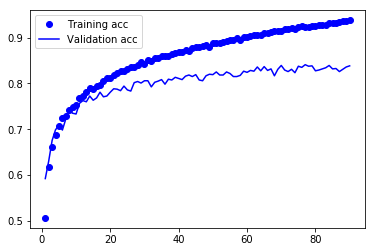

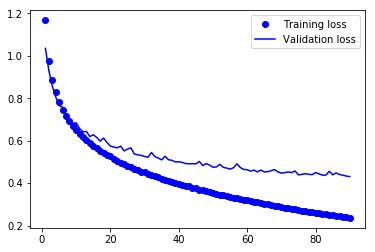

In [26]:
print_graphics (history)

In [27]:
print_evaluate_model(model, history)

acc: 79.42% - loss: 0.534959
